In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Mon Jan 15 19:13:20 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    13W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 38%   

### Model Parts

In [6]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.trainable_sigma_uniform_lse_latent_layer import LatentLayer
from model.decoder.mol_conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [7]:
def get_kl(M, N, k, post_sigma, elem_sigma, prior_sigma=1.0):
    # z : (M, z)
    # mu : (N, z)
    
    z = (torch.rand(M, k).cuda()*2-1) * prior_sigma
    mu = (torch.rand(N, k).cuda()*2-1) * post_sigma
            
    # (M, N) = sum((M, 1, z) - (1, N, z), dim=2)
    distance = torch.norm(z.unsqueeze(1) - mu.unsqueeze(0), dim=2) ** 2
    alpha = -1/(2*elem_sigma**2)
    loss = -torch.mean(torch.logsumexp(alpha*distance, dim=1), dim=0)
    loss = loss + 0.5*k*(2*np.log(elem_sigma)-np.log(np.e)) + np.log(N)
    
    return loss.item()

from tqdm import tqdm

M = 1024
N = 256
k = 2
post_sigma = 1
elem_log_sigmas = np.arange(-10, 10, 0.01)

losses_list = []
for _ in tqdm(range(10)):
    losses = np.array([get_kl(M, N, k, post_sigma, np.exp(elem_log_sigma)) for elem_log_sigma in elem_log_sigmas])
    losses_list.append(losses)
    
losses = np.median(np.array(losses_list), axis=0)
optimum_sigma = np.exp(elem_log_sigmas[np.argmin(losses)])
print(optimum_sigma, np.log(optimum_sigma))

losses = np.mean(np.array(losses_list), axis=0)
optimum_sigma = np.exp(elem_log_sigmas[np.argmin(losses)])
print(optimum_sigma, np.log(optimum_sigma))

100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.54it/s]

0.0963276382304773 -2.3400000000001633
0.11080315836231545 -2.2000000000001667


In [8]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 2
hp.init_log_sigma = -2.11
hp.h_dims = [32, 64, 128, 256, 512]

In [10]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.006843566894531
encoder.convs 5.9912109375
encoder.linear 0.01563262939453125
latent_layer 3.814697265625e-06
decoder 6.1512603759765625
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.1457672119140625
done


### Load

In [11]:
save_dir = '/data/scpark/save/lse/train01.15-2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 0


### Dataset

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [13]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = torch.tile(x, (1, 3, 1, 1)).to(device)
    data['t'] = t.to(device)
    return data

### Train

In [14]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


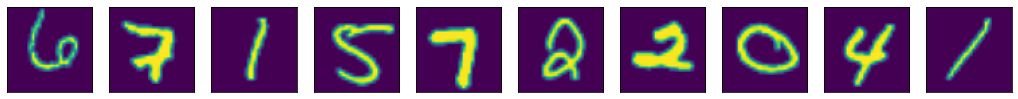

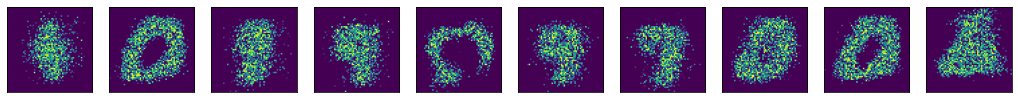

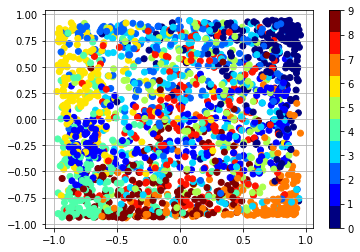

2001
lse_loss -1.2859811782836914
recon_loss 0.7418690919876099
2002
lse_loss -1.3017821311950684
recon_loss 0.7226202487945557
2003
lse_loss -1.2519769668579102
recon_loss 0.7110572457313538
2004
lse_loss -1.2671442031860352
recon_loss 0.7756794691085815
2005
lse_loss -1.3072147369384766
recon_loss 0.7276331186294556
2006
lse_loss -1.2983369827270508
recon_loss 0.7554647326469421
2007
lse_loss -1.2888803482055664
recon_loss 0.7268101572990417
2008
lse_loss -1.2834205627441406
recon_loss 0.7477469444274902
2009
lse_loss -1.286400318145752
recon_loss 0.6897166967391968
2010
lse_loss -1.323960304260254
recon_loss 0.7148323059082031
2011
lse_loss -1.3119192123413086
recon_loss 0.7154332399368286
2012
lse_loss -1.2876214981079102
recon_loss 0.6857571601867676
2013
lse_loss -1.2840147018432617
recon_loss 0.726325511932373
2014
lse_loss -1.3022241592407227
recon_loss 0.6806176900863647
2015
lse_loss -1.295785903930664
recon_loss 0.724044680595398
2016
lse_loss -1.305140495300293
recon_loss 0

lse_loss -1.2894706726074219
recon_loss 0.7806001901626587
2131
lse_loss -1.299426555633545
recon_loss 0.7577524185180664
2132
lse_loss -1.270833969116211
recon_loss 0.8090506196022034
2133
lse_loss -1.315389633178711
recon_loss 0.7567619681358337
2134
lse_loss -1.2940521240234375
recon_loss 0.7633309364318848
2135
lse_loss -1.2807016372680664
recon_loss 0.765092134475708
2136
lse_loss -1.2944254875183105
recon_loss 0.7361844778060913
2137
lse_loss -1.3287248611450195
recon_loss 0.7835164070129395
2138
lse_loss -1.3139104843139648
recon_loss 0.7457567453384399
2139
lse_loss -1.2999281883239746
recon_loss 0.7270137071609497
2140
lse_loss -1.2814674377441406
recon_loss 0.7380896806716919
2141
lse_loss -1.295334815979004
recon_loss 0.7829981446266174
2142
lse_loss -1.335587501525879
recon_loss 0.7661373615264893
2143
lse_loss -1.2928094863891602
recon_loss 0.7688853144645691
2144
lse_loss -1.297327995300293
recon_loss 0.8109415173530579
2145
lse_loss -1.2954120635986328
recon_loss 0.77630

2261
lse_loss -1.2993535995483398
recon_loss 0.7249444127082825
2262
lse_loss -1.299966812133789
recon_loss 0.7239679098129272
2263
lse_loss -1.3219833374023438
recon_loss 0.706367015838623
2264
lse_loss -1.2833023071289062
recon_loss 0.7464956045150757
2265
lse_loss -1.280749797821045
recon_loss 0.7880125045776367
2266
lse_loss -1.3328704833984375
recon_loss 0.9787521362304688
2267
lse_loss -1.3041629791259766
recon_loss 0.7283782362937927
2268
lse_loss -1.2675776481628418
recon_loss 0.9132576584815979
2269
lse_loss -1.320359230041504
recon_loss 0.7839744091033936
2270
lse_loss -1.3190126419067383
recon_loss 0.7308781743049622
2271
lse_loss -1.2906384468078613
recon_loss 0.8058160543441772
2272
lse_loss -1.2992515563964844
recon_loss 0.7277415990829468
2273
lse_loss -1.3278493881225586
recon_loss 0.8311271667480469
2274
lse_loss -1.2884554862976074
recon_loss 0.7366522550582886
2275
lse_loss -1.2923460006713867
recon_loss 0.8025225400924683
2276
lse_loss -1.2815756797790527
recon_loss

lse_loss -1.3243494033813477
recon_loss 0.6495916247367859
2391
lse_loss -1.2931394577026367
recon_loss 0.6215686798095703
2392
lse_loss -1.3306174278259277
recon_loss 0.6534210443496704
2393
lse_loss -1.305032730102539
recon_loss 0.6605457663536072
2394
lse_loss -1.272599220275879
recon_loss 0.6736645698547363
2395
lse_loss -1.3187274932861328
recon_loss 0.6821445226669312
2396
lse_loss -1.3182058334350586
recon_loss 0.6734150648117065
2397
lse_loss -1.2827653884887695
recon_loss 0.7074539065361023
2398
lse_loss -1.3008708953857422
recon_loss 0.6877480745315552
2399
lse_loss -1.279712200164795
recon_loss 0.7683773040771484
2400
lse_loss -1.3214235305786133
recon_loss 1.0582776069641113
2401
lse_loss -1.3052597045898438
recon_loss 1.0725197792053223
2402
lse_loss -1.3048033714294434
recon_loss 1.0219316482543945
2403
lse_loss -1.325551986694336
recon_loss 0.9933034181594849
2404
lse_loss -1.298475742340088
recon_loss 0.9836429953575134
2405
lse_loss -1.3100404739379883
recon_loss 0.978

lse_loss -1.3152713775634766
recon_loss 0.7195725440979004
2520
lse_loss -1.3056998252868652
recon_loss 0.7132551670074463
2521
lse_loss -1.26963472366333
recon_loss 0.7183362245559692
2522
lse_loss -1.3117671012878418
recon_loss 0.7187450528144836
2523
lse_loss -1.3135509490966797
recon_loss 0.7290804386138916
2524
lse_loss -1.2835216522216797
recon_loss 0.7798886895179749
2525
lse_loss -1.3257293701171875
recon_loss 0.7681812047958374
2526
lse_loss -1.3258075714111328
recon_loss 0.7029691338539124
2527
lse_loss -1.2887392044067383
recon_loss 0.6811619400978088
2528
lse_loss -1.282945156097412
recon_loss 0.7329741716384888
2529
lse_loss -1.2939538955688477
recon_loss 0.7898082733154297
2530
lse_loss -1.266733169555664
recon_loss 0.7345107197761536
2531
lse_loss -1.3236823081970215
recon_loss 0.693827748298645
2532
lse_loss -1.3198175430297852
recon_loss 0.7142987847328186
2533
lse_loss -1.3203611373901367
recon_loss 0.7622699737548828
2534
lse_loss -1.2411279678344727
recon_loss 0.745

2648
lse_loss -1.2964258193969727
recon_loss 0.6562751531600952
2649
lse_loss -1.313507080078125
recon_loss 0.6522790789604187
2650
lse_loss -1.3170523643493652
recon_loss 0.6374025344848633
2651
lse_loss -1.3340740203857422
recon_loss 0.6340287327766418
2652
lse_loss -1.2460746765136719
recon_loss 0.6366357803344727
2653
lse_loss -1.309049129486084
recon_loss 0.6228183507919312
2654
lse_loss -1.3110904693603516
recon_loss 0.6212323904037476
2655
lse_loss -1.2966737747192383
recon_loss 0.6323755383491516
2656
lse_loss -1.2497334480285645
recon_loss 0.6297893524169922
2657
lse_loss -1.3229031562805176
recon_loss 0.6181734204292297
2658
lse_loss -1.2918453216552734
recon_loss 0.6240625381469727
2659
lse_loss -1.2987775802612305
recon_loss 0.6627665162086487
2660
lse_loss -1.2975196838378906
recon_loss 0.7595081925392151
2661
lse_loss -1.3051471710205078
recon_loss 0.8523313999176025
2662
lse_loss -1.3114013671875
recon_loss 0.6624415516853333
2663
lse_loss -1.273632526397705
recon_loss 1

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=1024)

            # Backward
            loss = 0
            for key in data.keys():
                if 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024)
            
            plot(data['x'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        